In [1]:
# Add path
import sys
sys.path.insert(1, '../src')

# Packages for Our filters
import measfilter as mf 
import gatesimu as gs 

# Updated Qiskit Imports for v1.0+
from qiskit import QuantumRegister, transpile
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram

# Needed for functions
import numpy as np
import matplotlib.pyplot as plt

# Tutorial

## Section 1: Measurmenet Error
### Create filter for measurment error

First, we choose a backend to operate.

In [2]:
# Use the Aer Simulator
backend = AerSimulator()

# OPTIONAL: Add noise to make the simulation realistic
# Without this, the simulator is perfect and there are no errors to mitigate.
from qiskit_aer.noise import NoiseModel, depolarizing_error, ReadoutError

noise_model = NoiseModel()
# Add 5% readout error
noise_model.add_all_qubit_readout_error(ReadoutError([[0.95, 0.05], [0.05, 0.95]]))
# Add 1% gate error
noise_model.add_all_qubit_quantum_error(depolarizing_error(0.01, 1), ['u1', 'u2', 'u3', 'x', 'h'])

# Configure backend with noise
backend = AerSimulator(noise_model=noise_model)

We plan to run Grover's search whose solution is 11. So we first look at which quibits we will need to get information. The circuit will run on Qubit 0, 1, and 2. But the measurment operation is only on Qubit 1 and 2.

In [3]:
interested_qubits = [2,1] # Descending order because Qiskit's readout is little-endian

Now we collect data for our filter. Here we make `if_write=True` so that we can save the data and re-create the filter anytime we want. But no matter if `if_write=True` or not, a file that records backend proporties will be generated under `file_address`. if `file_address` is an empty string, the data will be saved where the script runs, otherwise `file_address` need to end with `/`.

By default, `itr * shots / 1024` number of data points will be used for Bayesian inference latter. `32 * 8192` usually takes a few minutes.

In [4]:
itr = 32
shots = 8192
file_address = 'Data/'
readout = mf.collect_filter_data(backend, itr=itr,shots=shots,
                                 if_write=True,
                                 file_address=file_address,
                                 job_id='')
# if a job has beeen submitted and run, you can retrieve the job data by
# job_id=some_id_string, where some_id_string is a string like '6307d28dd0466a73814bc1a8' 
# if you want to get new data, make job_id='', which is its default value

Note: Backend parameters could not be recorded (Backend properties not available.). Using defaults for inference.
Job id: 686f3849-076f-4cba-aa34-0dabb8ed5215


Then we can create our filter and run `inference()` to inference the data. If  `inference()` is run once, `post_from_file()` can directly read previous posteriors.

Qubit 2
Given Lambdas [0.9822 0.9852]


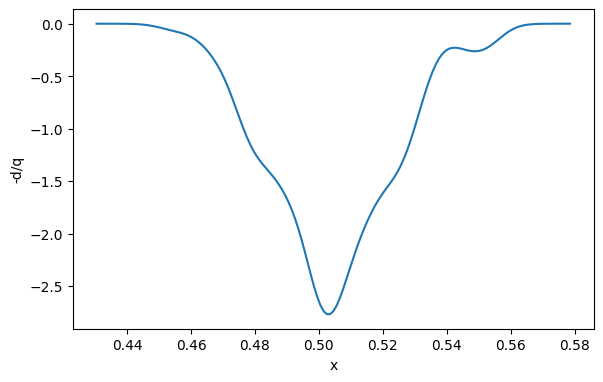

Final Accepted Posterior Lambdas
M: 2.77055 Maximizer: 0.502985 pi_obs = 27.1272 pi_Q(prior) = 9.79127
Progress: 99.997%
Accepted Number N: 14599, fraction 0.365
I(pi^post_Lambda) = 1
Posterior Lambda Mean [0.93217051 0.92655182]
Posterior Lambda Mode [0.95958713 0.94087526]
0 to 1: KL-Div(pi_D^Q(post),pi_D^obs) = 0.000676187
0 to 1: KL-Div(pi_D^obs,pi_D^Q(post)) =    inf


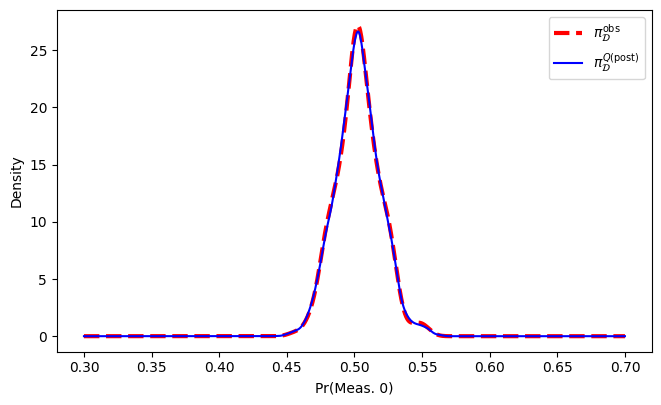

Qubit 1
Given Lambdas [0.9812 0.9821]


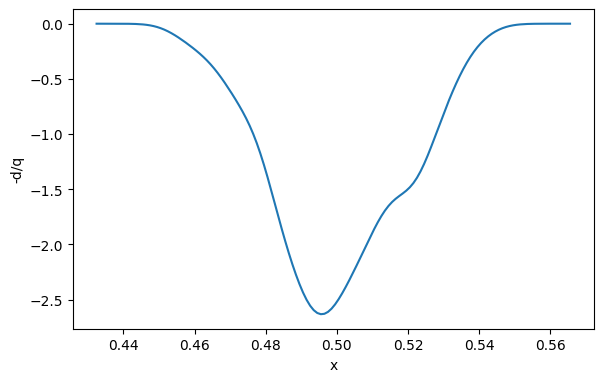

Final Accepted Posterior Lambdas
M: 2.63322 Maximizer: 0.49574 pi_obs = 25.9385 pi_Q(prior) = 9.85048
Progress: 99.997%
Accepted Number N: 15315, fraction 0.383
I(pi^post_Lambda) = 1
Posterior Lambda Mean [0.92847148 0.92823272]
Posterior Lambda Mode [0.95922065 0.94089586]
0 to 1: KL-Div(pi_D^Q(post),pi_D^obs) = 0.000142356
0 to 1: KL-Div(pi_D^obs,pi_D^Q(post)) =    inf


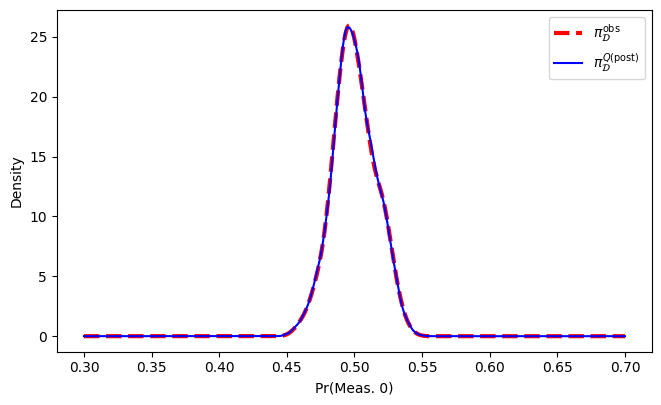

In [5]:
Cons_filter = mf.MeasFilter(interested_qubits, file_address=file_address)
Cons_filter.inference(nPrior=40000, Priod_sd=0.1, seed=127, shots_per_point=1024)

In [6]:
Cons_filter.mean()

{'Qubit2': array([0.93217051, 0.92655182]),
 'Qubit1': array([0.92847148, 0.92823272])}

In [7]:
Cons_filter.mode()

{'Qubit2': array([0.95958713, 0.94087526]),
 'Qubit1': array([0.95922065, 0.94089586])}

### Measurement error mitigation on a 3-qubit Grover's search experiment

Run provided Grover's search experiment, the counts will be written to `Count_Grover.csv`. Then we read the data back.

In [8]:
# Running the Grover experiment on the simulator
from expfuncs import Groverexp
Groverexp(backend, file_address=file_address)

Grover circuit depth is  23
Job id: 5fb3414f-0232-4c00-8d06-722b9dc2ddf2


In [9]:
# Read Grover data
import csv
with open(file_address + 'Count_Grover.csv', mode='r') as sgm:
    reader = csv.reader(sgm)
    temp_counts = {}
    for row in reader:   
        temp_counts[row[0]] = int(row[1])
real_counts = {}
for key in temp_counts.keys():
    real_counts[key[0:2]] = temp_counts[key] # we only measurmeent last two qubits, so slice the keys

In [10]:
mean_counts = Cons_filter.filter_mean(real_counts)
mode_counts = Cons_filter.filter_mode(real_counts)

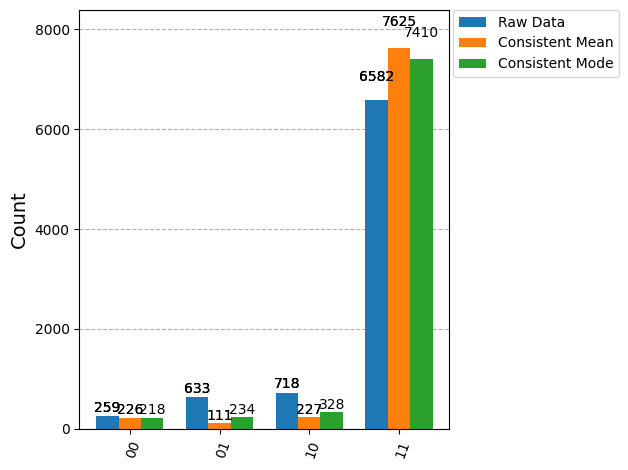

In [11]:
legend = ['Raw Data', 'Consistent Mean', 'Consistent Mode']
plot_histogram([real_counts, mean_counts, mode_counts], legend=legend)

We can see the mean and mode error rate from consistent Bayesian gives better error mitigation results than the error rates estimated from the measurement error filter in Qiskit

## Section 2: Gate and Measurmenet Error

Let us now use a 200-NOT-gate circuit as the benchmarking circuit to show how we use consistent Bayesian to estimate measurement error rates and gate error rates at the same time. Then we use the estimated error rates to filter out the measurement and gate errors. We measure the benchmarking circuit for $32 \cdot 8192$ times. The ideal probability of measurement 0 in this benchmarking circuit is 1.

In [12]:
interested_qubits = [4]
gate_num = 200
gate_type = 'X'

# Collect X Gate Data
for q in interested_qubits:
    gs.Gateexp(gate_num, gate_type, q, itr, backend, file_address =file_address, job_id='')
# if a job has beeen submitted and run, you can retrieve the job data by
# job = backend.retrieve_job(job_id), where job_id is a string like '6307d2f01590d431ad56f07a' 

Circ depth is  201
New Job submitted. Job ID: fcd471f3-b65a-487d-bb03-1c5100231ffd
Data saved to Data/Readout_200XQ4.csv


Qubit 4
Given Lambdas [9.47800000e-01 9.66800000e-01 6.30979702e-04]


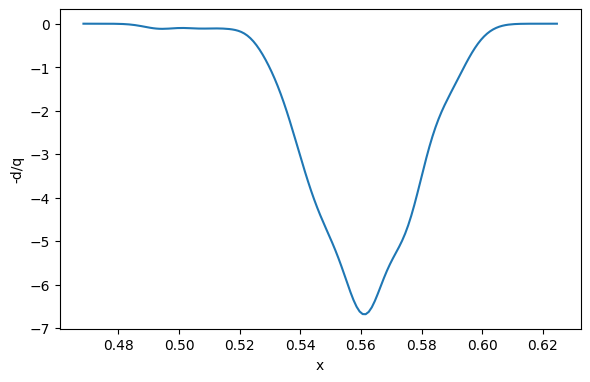

Final Accepted Posterior Lambdas
M: 6.68578 Maximizer: 0.561109 pi_obs = 25.2216 pi_Q(prior) = 3.77243
Accepted Number N: 6058, fraction 0.151
I(pi^post_Lambda) = 1
Posterior Lambda Mean [0.90418108 0.9043241  0.00915247]
Posterior Lambda Mode [0.92930694 0.94520715 0.00993967]
0 to 1: KL-Div(pi_D^Q(post),pi_D^obs) = 0.00183146
0 to 1: KL-Div(pi_D^obs,pi_D^Q(post)) =    inf


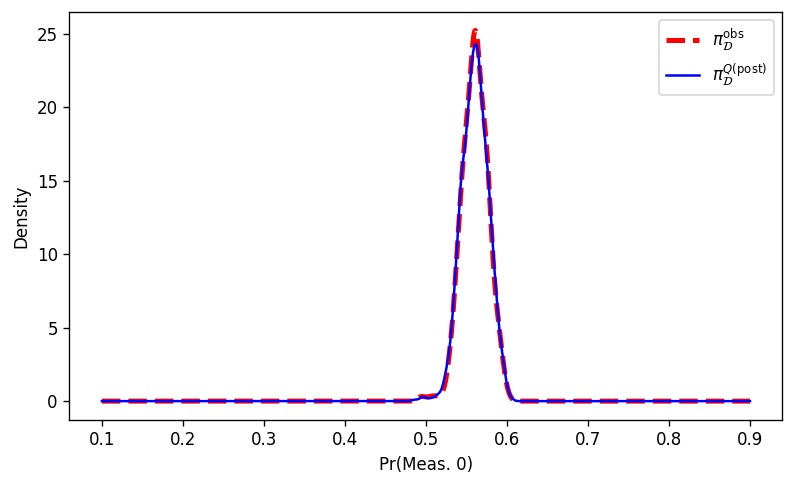

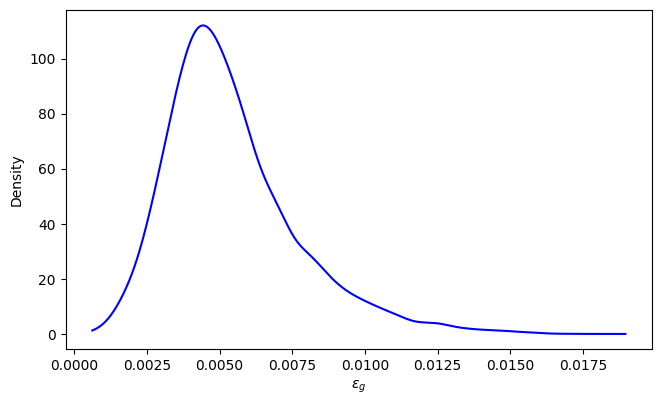

In [13]:
gs_filter = gs.GMFilter(interested_qubits,gate_num, gate_type, device_param_address=file_address, data_file_address=file_address)
gs_filter.inference(nPrior=40000, meas_sd=0.1, gate_sd=0.01, seed=127, shots_per_point=1024)
# gs_filter.post_from_file()

In function `mf.getData0()`, we split the $32\cdot 8192$ measurments to $128$ groups, and estimate one $\text{Pr}(\text{Measure} 0)$ for each group, i.e., use every 2048 shots to estimate one probability. Then, we use our filter to filter out measurement and gate errors in those 128 probailities to see how many of them can be very close to the ideal value 1.

In [14]:
# Read data back
with open(file_address + 'Readout_{}{}Q{}.csv'.format(gate_num, gate_type, interested_qubits[0]), mode='r') as measfile:
    reader = csv.reader(measfile) 
    data1 = np.asarray([row for row in reader][0])

p0s1 = mf.getData0(data1, 128, interested_qubits[0])
Q1CB = gs_filter.filter_mean(p0s1, interested_qubits[0])

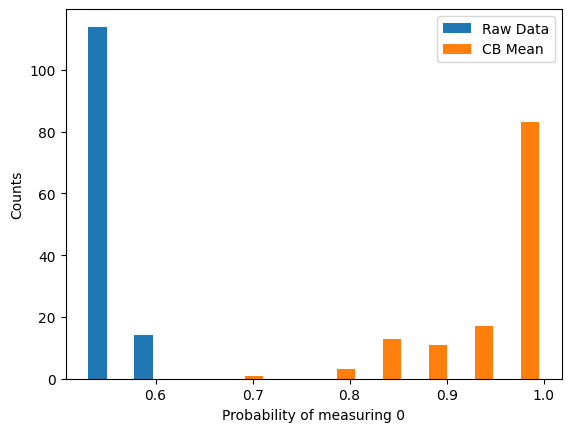

In [15]:
import matplotlib.pyplot as plt
plt.hist([p0s1, Q1CB], label = ['Raw Data', 'CB Mean'])
plt.xlabel('Probability of measuring 0')
plt.ylabel('Counts')
plt.legend()
plt.show()

It is clear that, after error filtering with the mean error rates, about 100 out of 128  $\text{Pr}(\text{Measure} 0)$ are close to the noise-free result.